In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jul  3 09:41:34 2021

@author: AOG
"""
#IMPORTATION OF LIBRARIES 
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns 

import sklearn.cluster
# overides the default look of matplotlib
sns.set()

from sklearn.preprocessing import StandardScaler


from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.cluster import KMeans 

from sklearn.decomposition import PCA

import pickle


In [3]:
#LOADING THE SAMPLE FILE
df_segmentation = pd.read_csv('M1_sorted.csv', index_col = 0 )

In [4]:
# DROPPING INTERVALS AFTER 1 PM
df_segmentation.drop(df_segmentation.tail(7322).index, inplace =True)
df_segmentation=df_segmentation[['Minimum','Mean','Maximum','Number of Observations']]

In [5]:
# FOR 6 AM
#  hours are 733 inices long
df_six_all = df_segmentation[:732]

# reassigning

df_segmentation = df_six_all
                                 
df_segmentation.head()

df_segmentation.describe()

,Minimum,Mean,Maximum,Number of Observations
count,732.000000,732.000000,732.000000,732.000000
mean,35.114754,47.316940,60.353825,6.554645
std,5.905359,6.095957,9.738535,2.730186
min,25.000000,41.000000,51.000000,3.000000
25%,31.000000,43.000000,54.000000,5.000000
50%,34.000000,46.000000,58.000000,6.000000
75%,38.000000,49.000000,62.000000,8.000000
max,60.000000,85.000000,120.000000,15.000000


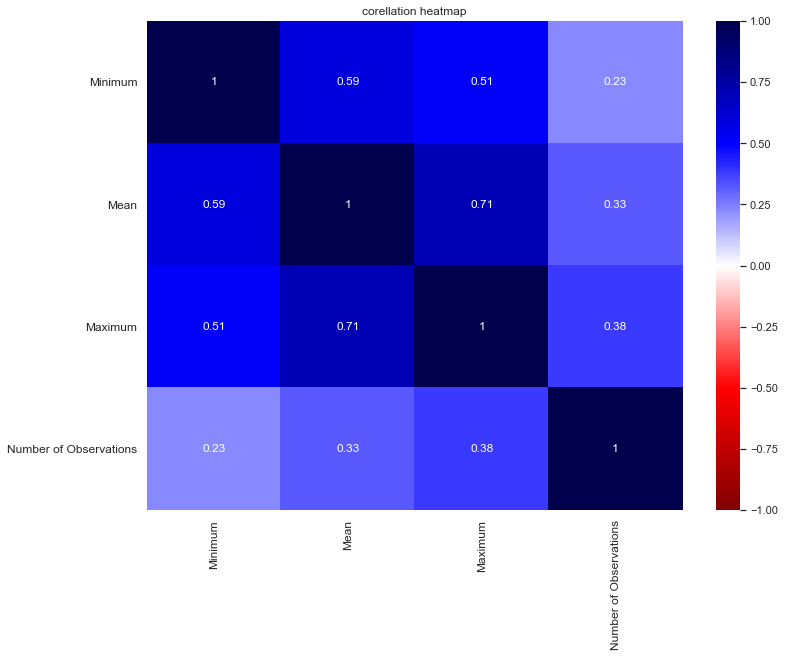

In [6]:
# container to visualize the data characteristics
correl_information = df_segmentation.corr()

# to view the corellation between the variables 
plt.figure(figsize=(12,9))
s = sns.heatmap(df_segmentation.corr(),
                annot = True,
                cmap='seismic_r',
                vmin=-1,
                vmax=1)
s.set_yticklabels(s.get_yticklabels(),rotation = 0,fontsize = 12)
s.set_xticklabels(s.get_xticklabels(),rotation = 90,fontsize = 12)
plt.title('corellation heatmap')
plt.show()



Text(0.5, 1.0, 'Visualisation of observations vs min,mean,max')

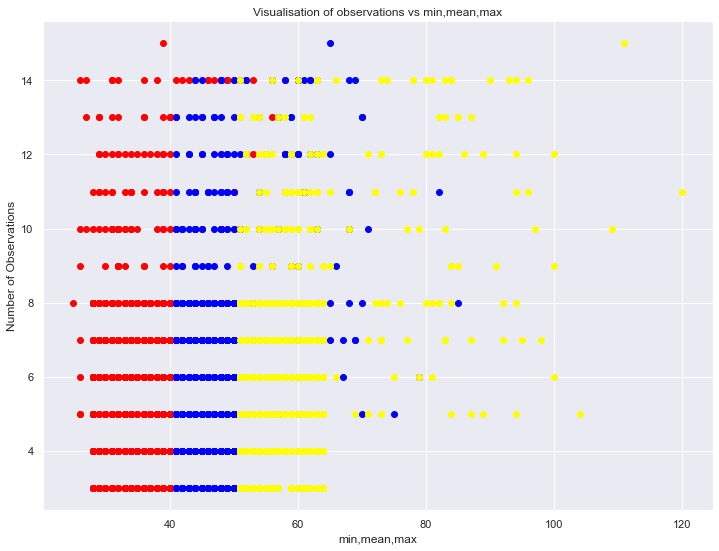

In [8]:
# for the min travel times of 6am
# to visualize the number of observations and the mean in raw form 
plt.figure(figsize=(12,9))
plt.scatter(df_segmentation.iloc[:,0],df_segmentation.iloc[:,3],c='red')
plt.scatter(df_segmentation.iloc[:,1],df_segmentation.iloc[:,3],c='blue')
plt.scatter(df_segmentation.iloc[:,2],df_segmentation.iloc[:,3],c='yellow')
plt.xlabel('min,mean,max')
plt.ylabel('Number of Observations')
plt.title('Visualisation of observations vs min,mean,max')

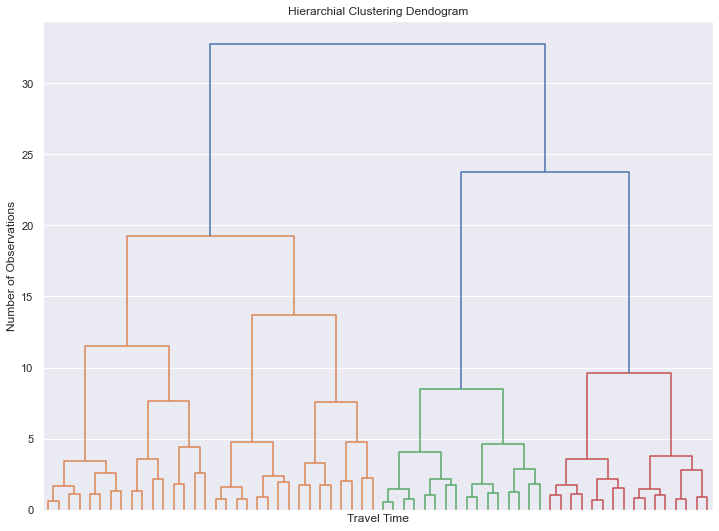

In [9]:
df_segmentation_min= df_segmentation[['Minimum','Number of Observations']]

df_segmentation = df_segmentation_min

scaler = StandardScaler()
segmentation_std=scaler.fit_transform(df_segmentation)


hier_clust = linkage(segmentation_std,method = 'ward')
# visualizing the num of clusters in the data 
plt.figure(figsize=(12,9))
plt.title('Hierarchial Clustering Dendogram')
plt.xlabel('Travel Time')
plt.ylabel('Number of Observations')
dendrogram(hier_clust,
            truncate_mode='level',
            p = 5,
          show_leaf_counts = False,
          no_labels =True)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


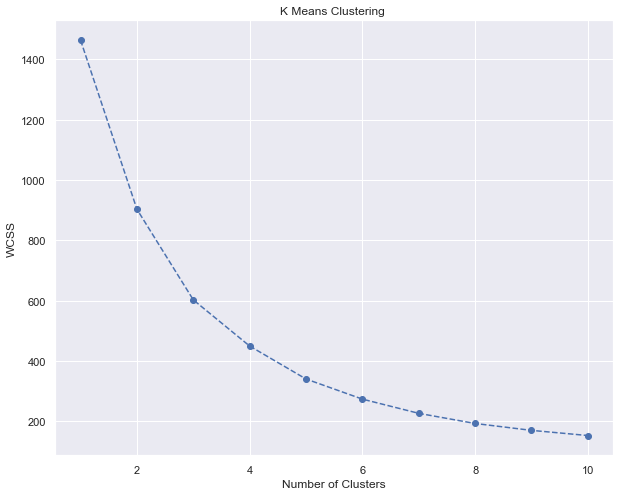

In [10]:
# confirming the number of clusters by elbow method 
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',random_state=33)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K Means Clustering ')
plt.show()

In [12]:
# setting the number of clusters of the k-means to 2
kmeans = KMeans(n_clusters = 3, init = 'k-means++',random_state=33)
     
# FITTING THE DATA TO K-MEANS MODEL
kmeans.fit(segmentation_std)

KMeans(n_clusters=3, random_state=33)

In [13]:
# for the cluster centres

cluster_centres = kmeans.cluster_centers_

In [14]:
# analysing the results and grouping clusters


df_segm_kmeans =  df_segmentation.copy()

# to create a new column
df_segm_kmeans['Segment K-Means'] = kmeans.labels_ #adds a column indicating the labels
df_segm_analysis = df_segm_kmeans.groupby('Segment K-Means').mean()
df_segm_analysis 

# to estimate the size of each cluster /number of observation and probability 
df_segm_analysis['N Obs'] = df_segm_kmeans[['Minimum','Segment K-Means']].groupby(['Segment K-Means']).count()
df_segm_analysis['Props Obs']= df_segm_analysis['N Obs']/df_segm_analysis['N Obs'].sum()

df_segm_analysis

df_segm_analysis.rename({0:'high_minimum_travel_time',
                         1:'low_minimum_travel_time'})

,Minimum,Number of Observations,N Obs,Props Obs
Segment K-Means,,,,
high_minimum_travel_time,33.774648,8.616197,284,0.387978
low_minimum_travel_time,34.020151,4.604534,397,0.542350
2,51.098039,10.254902,51,0.069672


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


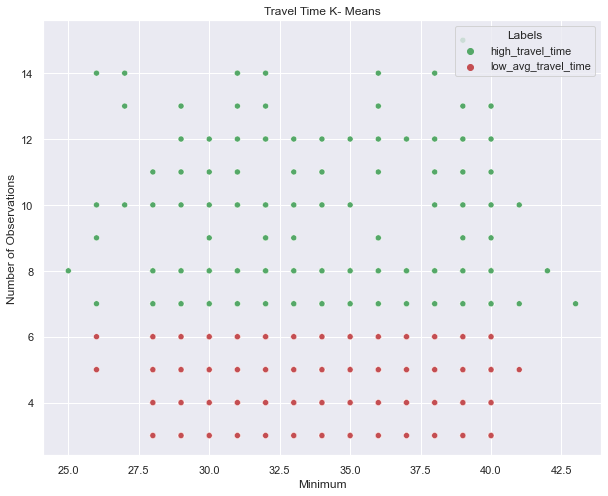

In [15]:
# plotting the raw data

df_segm_kmeans['Labels']= df_segm_kmeans['Segment K-Means'].map({0:'high_travel_time',
                                                                 1:'low_avg_travel_time'})
x_axis = df_segm_kmeans['Minimum']
y_axis = df_segm_kmeans['Number of Observations']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis, hue = df_segm_kmeans['Labels'], palette=('g','r'))
plt.title('Travel Time K- Means')
plt.show()


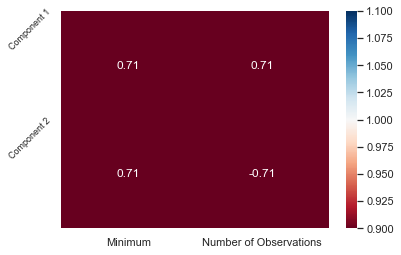

In [16]:
# applying pca to reduce the dimensionality of our variables
pca = PCA()

# FITTING THE DATA TO PCA MODEL
pca.fit(segmentation_std)
pca.explained_variance_ratio_

# analysing to determine the number of components for the pca model
# plt.figure(figsize=(12,9))
# plt.plot(range(0,1),pca.explained_variance_ratio_.cumsum(),marker ='o',linestyle = '--')
# plt.title('Explained vairiance by components')
# plt.xlabel('Number of components ')
# plt.ylabel('Explained variance')

pca = PCA(n_components=2)#from plot above
pca.fit(segmentation_std)

# PCA Results analyses 
pca.components_

# visualising in seaborn
df_pca_comp = pd.DataFrame(data= pca.components_,columns =  df_segmentation.columns.values,index = ['comonent 1','component 2'])
sns.heatmap(df_pca_comp,
            vmin=1,
            vmax=1,
            cmap='RdBu',annot = True)
plt.yticks([0,1],['Component 1','Component 2'],rotation = 45, fontsize= 9)

pca.transform(segmentation_std)

scores_pca = pca.transform(segmentation_std)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


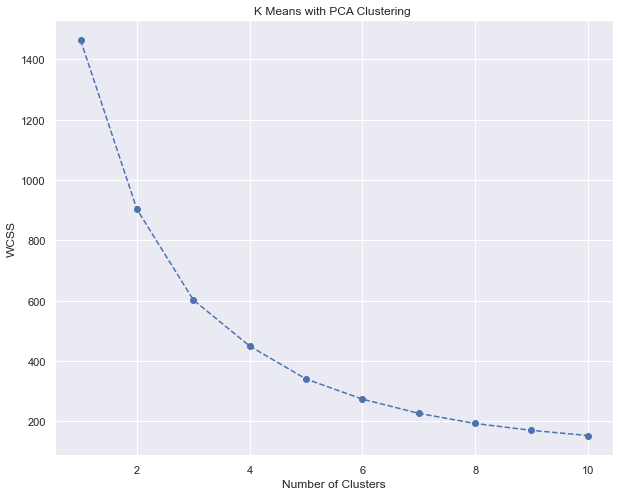

In [17]:
# pca with kmeans 
# the algorithm can be run with different iterations to see the result
wcss=[]
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++',random_state=33)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K Means with PCA Clustering ')
plt.show()

In [18]:
kmeans_pca= KMeans(n_clusters = 2, init = 'k-means++',random_state = 42)

kmeans_pca.fit(scores_pca)
# for the clusters

pca_cluster_centres=kmeans_pca.cluster_centers_

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


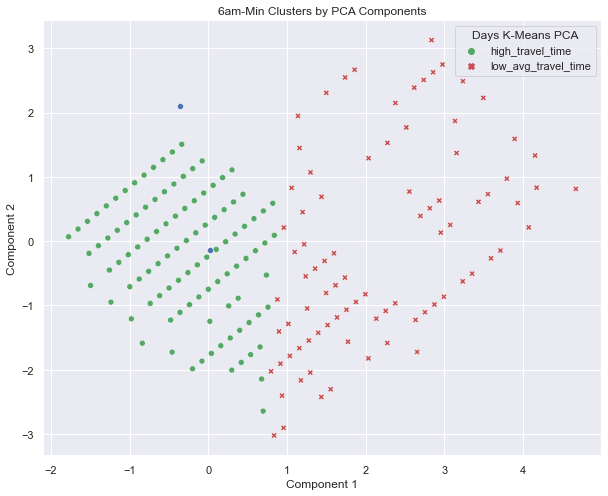

In [19]:
# pca results analysis 
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True),pd.DataFrame(scores_pca)],axis = 1)
df_segm_pca_kmeans.columns.values[-2:] = ['Component 1','Component 2']
df_segm_pca_kmeans['Days K-Means PCA'] = kmeans_pca.labels_

df_segm_pca_kmeans

# # to calculate the mean usinf the groupby method
# df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-Means PCA']).mean()
# df_segm_pca_kmeans_freq 

# df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-Means PCA','Sex']].groupby(['Segment K-Means PCA']).count()
# df_segm_pca_kmeans_freq['Props Obs']= df_segm_pca_kmeans_freq['N Obs']/df_segm_pca_kmeans_freq['N Obs'].sum()
# df_segm_pca_kmeans_freq = df_segm_analysis.rename({0:'well-off',
#                           1:'fewer-oppurtunities',
#                           2:'standard',
#                           3:'career-focused'})
# plotting the raw data using two of the most significant axes as components 
df_segm_pca_kmeans['legend'] =  df_segm_pca_kmeans['Days K-Means PCA'].map({0:'high_travel_time',
                         1:'low_avg_travel_time'})

x_axis = df_segm_pca_kmeans['Component 1']
y_axis = df_segm_pca_kmeans['Component 2']
plt.figure(figsize = (10,8))
sns.scatterplot(pca_cluster_centres[0],pca_cluster_centres[1], palette=('orange'))
sns.scatterplot(x_axis,y_axis, hue = df_segm_pca_kmeans['Days K-Means PCA'].map({0:'high_travel_time',
                         1:'low_avg_travel_time'}), style = df_segm_pca_kmeans['Days K-Means PCA'].map({0:'high_travel_time',
                         1:'low_avg_travel_time'}), palette=('g','r'))
plt.title('6am-Min Clusters by PCA Components')
plt.show()

In [20]:
# printing to a document 
# from docx import Document 

# document = Document()
# CLUSTER_RESULTS = document.add_paragraph('Min 6hrs')

# pca_cluster_centres

# table = document.add_table(rows=8,cols=4)

# num = table.cell(1,1)
# table.cell(1,1).text = 'Time'
# num.text = '%d' % pca_cluster_centres[0,1]
